In [1]:
# Ячейка 1: Импорт библиотек
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg

In [2]:
# Ячейка 2: Загрузка и отображение изображения
name = "card.jpeg"

try:
    img = Image.open(name)
    print(f"Изображение успешно загружено: {name}")
except FileNotFoundError:
    print(f"Файл {name} не найден! Убедитесь, что он находится в текущей директории.")
    # Создаем тестовое изображение, если файл не найден
    img = Image.new('RGB', (300, 200), color='blue')

Изображение успешно загружено: card.jpeg


Размер изображения: 700×525 пикселей
Формат: JPEG
Режим: RGB


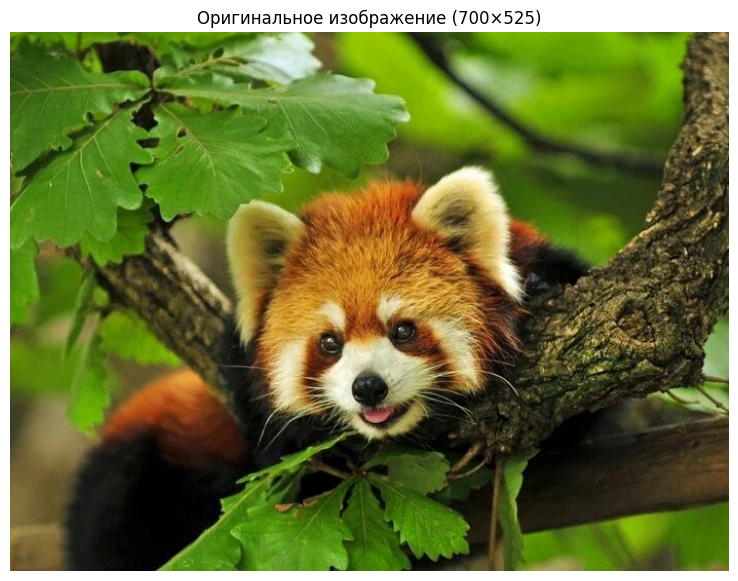

In [3]:
# Ячейка 3: Показать информацию об изображении
w, h = img.size
print(f"Размер изображения: {w}×{h} пикселей")
print(f"Формат: {img.format}")
print(f"Режим: {img.mode}")

plt.figure(figsize=(10, 7))
plt.imshow(img)
plt.title(f"Оригинальное изображение ({w}×{h})")
plt.axis('off')
plt.show()

In [4]:
# Ячейка 4: Преобразование в numpy массив и нормализация
img_array = np.array(img, dtype=np.float32)
print(f"Размер массива: {img_array.shape}")
print(f"Диапазон значений: от {img_array.min():.1f} до {img_array.max():.1f}")

# Нормализация значений от 0 до 1
img_array = img_array / 255.0
print(f"После нормализации: от {img_array.min():.3f} до {img_array.max():.3f}")

# Разделение на цветовые каналы (RGB)
channels = []
channel_names = ['Красный', 'Зеленый', 'Синий']

for i in range(3):
    channel = img_array[:, :, i]
    channels.append(channel)
    print(f"Канал {channel_names[i]}: {channel.shape}, среднее значение: {channel.mean():.3f}")

Размер массива: (525, 700, 3)
Диапазон значений: от 0.0 до 255.0
После нормализации: от 0.000 до 1.000
Канал Красный: (525, 700), среднее значение: 0.352
Канал Зеленый: (525, 700), среднее значение: 0.390
Канал Синий: (525, 700), среднее значение: 0.133


In [5]:
# Ячейка 5: Функция для применения SVD
def apply_svd(channel, k=50):
    """
    Применяет SVD сжатие к одному каналу изображения.
    
    Args:
        channel: 2D массив одного цветового канала
        k: количество оставляемых сингулярных значений
    
    Returns:
        channel_approx: восстановленный канал после сжатия
        s: массив сингулярных значений
    """
    U, s, Vt = linalg.svd(channel, full_matrices=False)
    
    # Оставляем только k сингулярных значений
    s_k = np.zeros_like(s)
    s_k[:k] = s[:k]
    
    # Восстанавливаем матрицу
    channel_approx = U @ np.diag(s_k) @ Vt
    
    # Ограничиваем значения от 0 до 1
    channel_approx = np.clip(channel_approx, 0, 1)
    
    return channel_approx, s

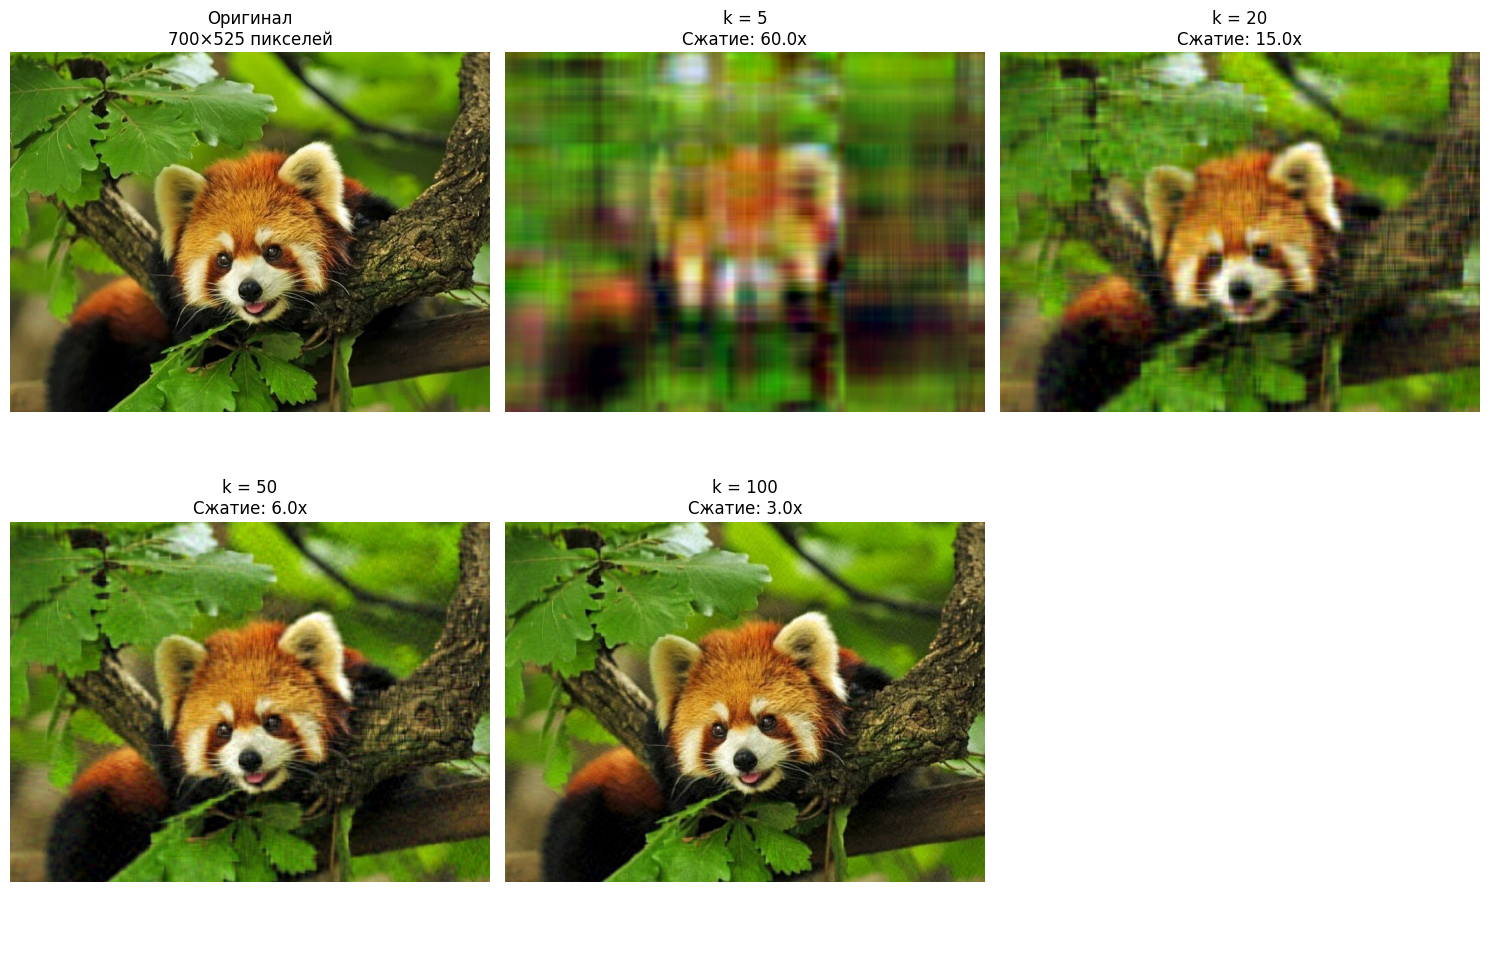

In [6]:
# Ячейка 6: Применение SVD с разным количеством компонент
# Значения k для тестирования
k_values = [5, 20, 50, 100]

# Создаем фигуру для отображения результатов
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Отображаем оригинальное изображение в левом верхнем углу
axes[0, 0].imshow(img_array)
axes[0, 0].set_title(f"Оригинал\n{w}×{h} пикселей")
axes[0, 0].axis('off')

# Обрабатываем для разных значений k
for idx, k in enumerate(k_values, 1):
    row = idx // 3
    col = idx % 3
    
    # Применяем SVD к каждому каналу
    approx_channels = []
    for channel in channels:
        approx_channel, _ = apply_svd(channel, k)
        approx_channels.append(approx_channel)
    
    # Собираем изображение обратно
    img_approx = np.stack(approx_channels, axis=2)
    
    # Вычисляем коэффициент сжатия
    original_size = w * h * 3  # пиксели * 3 канала
    compressed_size = k * (w + h + 1) * 3  # k*(ширина+высота+1)*3 канала
    compression_ratio = original_size / compressed_size
    
    # Отображаем результат
    axes[row, col].imshow(img_approx)
    axes[row, col].set_title(f"k = {k}\nСжатие: {compression_ratio:.1f}x")
    axes[row, col].axis('off')

# Удаляем пустые оси, если есть
if len(k_values) < 5:
    for i in range(len(k_values) + 1, 6):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Ячейка 7: Сравнение качества при разных k
# Создадим таблицу сравнения
print("Сравнение качества восстановления при разных k:")
print("-" * 65)
print(f"{'k':<5} {'Сжатие':<10} {'Информация (%)':<15} {'Качество'}")
print("-" * 65)

for k in [1, 5, 10, 20, 30, 50, 100]:
    # Вычисляем коэффициент сжатия
    compressed_size = k * (w + h + 1) * 3
    compression_ratio = (w * h * 3) / compressed_size
    
    # Вычисляем процент сохраненной информации
    info_percent = s[:k].sum() / s.sum() * 100
    
    # Оценка качества
    if k <= 5:
        quality = "Очень низкое"
    elif k <= 20:
        quality = "Низкое"
    elif k <= 50:
        quality = "Среднее"
    elif k <= 100:
        quality = "Хорошее"
    else:
        quality = "Отличное"
    
    print(f"{k:<5} {compression_ratio:<10.1f}x {info_percent:<15.1f} {quality}")

Сравнение качества восстановления при разных k:
-----------------------------------------------------------------
k     Сжатие     Информация (%)  Качество
-----------------------------------------------------------------
1     299.8     x 20.8            Очень низкое
5     60.0      x 33.8            Очень низкое
10    30.0      x 42.9            Низкое
20    15.0      x 52.7            Низкое
30    10.0      x 59.0            Среднее
50    6.0       x 67.3            Среднее
100   3.0       x 79.4            Хорошее
